In [4]:
import os
from pathlib import Path

# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive-CoDec':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

In [1]:
# Download dataset
# from huggingface_hub import snapshot_download
# snapshot_download(repo_id="EMERGE-lab/GPUDrive_mini", repo_type="dataset", local_dir="data/processed")

In [5]:
import torch
import dataclasses
import mediapy
from huggingface_hub import PyTorchModelHubMixin
from huggingface_hub import ModelCard
from gpudrive.networks.late_fusion import NeuralNet

from gpudrive.env.config import EnvConfig
from gpudrive.env.env_torch import GPUDriveTorchEnv, GPUDriveConstrualEnv
from gpudrive.visualize.utils import img_from_fig
from gpudrive.env.dataset import SceneDataLoader
from gpudrive.utils.config import load_config

### Configs

In [6]:
# Configs model has been trained with
config = load_config("examples/experimental/config/reliable_agents_params")
print(config)

# datase_path='data/processed/examples',
# datase_path='data/processed/training',
datase_path = 'data/processed/construal'

max_agents = config.max_controlled_agents
num_envs = 20
device = "cpu" # cpu just because we're in a notebook
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Other changes to variables
config.max_controlled_agents = 1    # Control only the first vehicle in the environment
num_envs = min(num_envs, len(os.listdir(datase_path)))

{'max_controlled_agents': 64, 'ego_state': True, 'road_map_obs': True, 'partner_obs': True, 'norm_obs': True, 'remove_non_vehicles': True, 'lidar_obs': False, 'reward_type': 'weighted_combination', 'collision_weight': -0.75, 'off_road_weight': -0.75, 'goal_achieved_weight': 1.0, 'dynamics_model': 'classic', 'collision_behavior': 'ignore', 'dist_to_goal_threshold': 2.0, 'polyline_reduction_threshold': 0.1, 'sampling_seed': 42, 'obs_radius': 50.0, 'action_space_steer_disc': 13, 'action_space_accel_disc': 7, 'init_mode': 'all_non_trivial'}


### Load pre-trained agent via Hugging Face hub


In [ ]:
sim_agent = NeuralNet.from_pretrained("daphne-cornelisse/policy_S10_000_02_27")

In [ ]:
# Agent has an action dimension of 91: 13 steering wheel angle discretizations x 9 acceleration discretizations
sim_agent.action_dim

91

In [ ]:
# Size of flattened observation vector
sim_agent.obs_dim

2984

In [ ]:
# Some other info
card = ModelCard.load("daphne-cornelisse/policy_S10_000_02_27")
card.data.tags

['ffn', 'model_hub_mixin', 'pytorch_model_hub_mixin']

In [ ]:
# Model architecture
#agent

In [ ]:
# Weights 
#agent.state_dict()

In [ ]:
os.listdir('data/processed/construal')

['tfrecord-00010-of-01000_33.json',
 'tfrecord-00012-of-01000_74.json',
 'tfrecord-00008-of-01000_478.json']

### Make environment

In [ ]:
# Create data loader
train_loader = SceneDataLoader(
    root=datase_path,
    batch_size=num_envs,
    dataset_size=max(100,num_envs),
    sample_with_replacement=False,
)

# Set params
env_config = dataclasses.replace(
    EnvConfig(),
    ego_state=config.ego_state,
    road_map_obs=config.road_map_obs,
    partner_obs=config.partner_obs,
    reward_type=config.reward_type,
    norm_obs=config.norm_obs,
    dynamics_model=config.dynamics_model,
    collision_behavior=config.collision_behavior,
    dist_to_goal_threshold=config.dist_to_goal_threshold,
    polyline_reduction_threshold=config.polyline_reduction_threshold,
    remove_non_vehicles=config.remove_non_vehicles,
    lidar_obs=config.lidar_obs,
    disable_classic_obs=config.lidar_obs,
    obs_radius=config.obs_radius,
    steer_actions = torch.round(
        torch.linspace(-torch.pi, torch.pi, config.action_space_steer_disc), decimals=3  
    ),
    accel_actions = torch.round(
        torch.linspace(-4.0, 4.0, config.action_space_accel_disc), decimals=3
    ),
)

# |Make env
# env = GPUDriveTorchEnv(
#     config=env_config,
#     data_loader=train_loader,
#     max_cont_agents=config.max_controlled_agents,
#     device=device,
# )

# |Make env
env = GPUDriveConstrualEnv(
    config=env_config,
    data_loader=train_loader,
    max_cont_agents=config.max_controlled_agents,
    device=device,
)

In [ ]:
env.data_batch

['data/processed/construal/tfrecord-00008-of-01000_478.json',
 'data/processed/construal/tfrecord-00010-of-01000_33.json',
 'data/processed/construal/tfrecord-00012-of-01000_74.json']

### Use the agent

In [12]:
next_obs = env.reset()

control_mask = env.cont_agent_mask

next_obs.shape

torch.Size([2, 64, 2984])

In [13]:
action, logprob, entropy, value = sim_agent(
    next_obs[control_mask], deterministic=False
)

In [14]:
action.shape, logprob.shape, entropy.shape, value.shape

(torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2, 1]))

In [ ]:
curr_veh = control_mask.nonzero()[4]
control_mask[curr_veh[0], curr_veh[1]]
curr_veh

In [18]:
control_mask

tensor([[False,  True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [ True, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False

### Rollout

In [16]:
next_obs = env.reset()

control_mask = env.cont_agent_mask

print(next_obs.shape)

frames = {f"env_{i}": [] for i in range(num_envs)}

for time_step in range(env.episode_len):
    print(f"\rStep: {time_step}", end="", flush=True)

    # Predict actions
    action, _, _, _, _ = sim_agent(
        next_obs[control_mask], deterministic=False
    )
    action_template = torch.zeros(
        (num_envs, max_agents), dtype=torch.int64, device=device
    )
    action_template[control_mask] = action.to(device)

    # Step
    env.step_dynamics(action_template)

    # Render    
    sim_states = env.vis.plot_simulator_state(
        env_indices=list(range(num_envs)),
        time_steps=[time_step]*num_envs,
        zoom_radius=70,
    )
    
    for i in range(num_envs):
        frames[f"env_{i}"].append(img_from_fig(sim_states[i])) 

    next_obs = env.get_obs()
    reward = env.get_rewards()
    done = env.get_dones()
    info = env.get_infos()

    if done.all():
        break

# env.close()
#Rebase

torch.Size([3, 64, 2984])
Step: 0

Step: 90


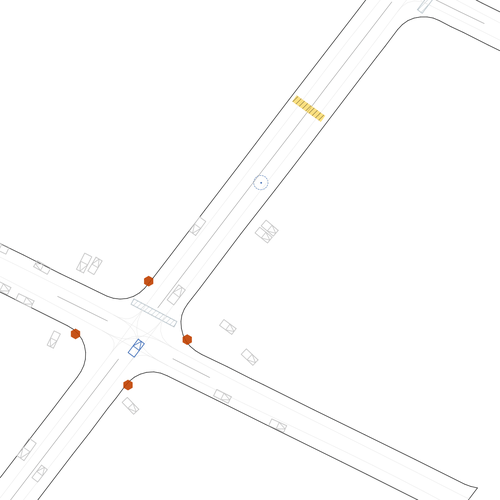
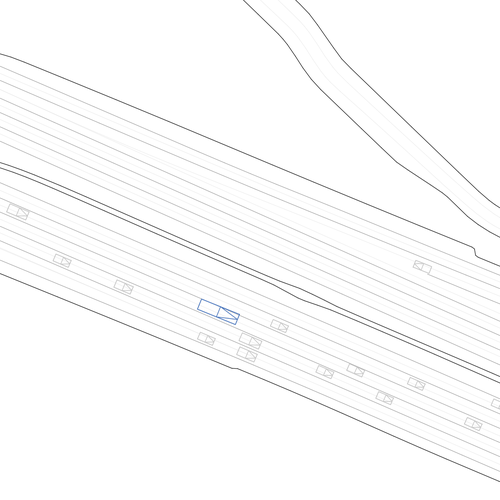
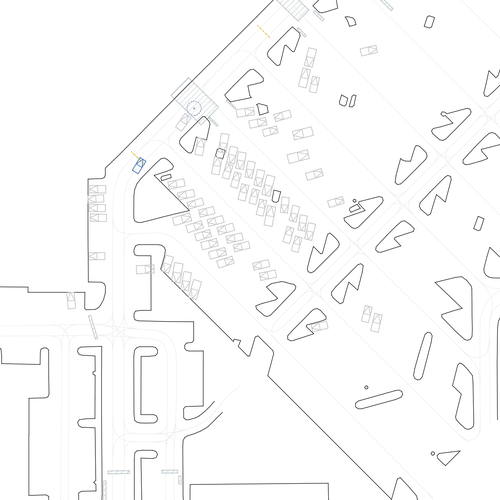

In [17]:
mediapy.set_show_save_dir('./sim_vids')
mediapy.show_videos(frames, fps=15, width=500, height=500, columns=2, codec='gif')

### Construal Simulation

In [ ]:
import math

In [14]:
construal_size = 5
observed_agents = max_agents - 1    # Agents observed except self (used for vector sizes)
limit_observed_agents = 40          # Maximum nember of agents to observe (used for loop counts)
construal_values = {}               # Dictionary that contains the expected utility per construal
sample_size = 5                     # Number of samples to calculate expected utility of a construal
for const_num in range(math.ceil(limit_observed_agents/construal_size)):
    # Repeat rollout for each construal

    next_obs = env.reset()
    control_mask = env.cont_agent_mask
    # print("Observation shape: ", next_obs.shape)
    frames = {f"env_{i}-constr_{const_num}": [] for i in range(num_envs)}

    ## Define observation mask for construal
    construal_mask = [False]*observed_agents
    mask_start_indx = int(const_num*construal_size)
    mask_end_indx = min(observed_agents, int( ((const_num+1)*construal_size)-1 ))
    # if mask_end_indx >= limit_observed_agents:
    #     break
    print("Construal indices: ", mask_start_indx, "-", mask_end_indx)
    construal_mask[mask_start_indx:mask_end_indx] = [True]*(mask_end_indx-mask_start_indx)
    
    curr_samples = []
    for i in range(sample_size):
        print("\tsample ", i)
        next_obs = env.reset()
        for time_step in range(env.episode_len):
            ## Roll out policy for a specific construal
            print(f"\r\t\tStep: {time_step}", end="", flush=True)

            ### Predict actions
            action, _, _, _ = sim_agent(
                next_obs[control_mask], deterministic=False
            )
            action_template = torch.zeros(
                (num_envs, max_agents), dtype=torch.int64, device=device
            )
            action_template[control_mask] = action.to(device)

            ### Step
            env.step_dynamics(action_template)

            ### Render
            sim_states = env.vis.plot_simulator_state(
                env_indices=list(range(num_envs)),
                time_steps=[time_step]*num_envs,
                zoom_radius=70,
            )
            
            for i in range(num_envs):
                frames[f"env_{i}-constr_{const_num}"].append(img_from_fig(sim_states[i])) 

            # next_obs = env.get_obs(obs_mask)
            next_obs = env.get_obs(partner_mask=construal_mask)
            reward = env.get_rewards()
            done = env.get_dones()
            info = env.get_infos()
            
            if done.all():
                break
        print() # Change to new line after step prints
            
        curr_samples.append(reward[control_mask].tolist())
    construal_values[(mask_start_indx,mask_end_indx)] = [sum(x)/sample_size for x in zip(*curr_samples)]

    ## Save animations
    # mediapy.set_show_save_dir('./sim_vids')
    # mediapy.show_videos(frames, fps=15, width=500, height=500, columns=2, codec='gif')

# env.close()
print("\nExpected utility by contrual: ", construal_values)

Construal indices:  0 - 5
	sample  0
		Step: 0

		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  5 - 10
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  10 - 15
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  15 - 20
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  20 - 25
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  25 - 30
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  30 - 35
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  35 - 40
	sample  0
		Step: 90
	sample  1
		Step: 90
	s

Expected utility by contrual:  {(0, 5): [1.0, 1.0, 1.0, 0.8], (5, 10): [1.0, 1.0, 1.0, 1.0], (10, 15): [1.0, 1.0, 1.0, 1.0], (15, 20): [1.0, 1.0, 0.8, 1.0], (20, 25): [1.0, 1.0, 1.0, 1.0], (25, 30): [1.0, 1.0, 0.8, 1.0], (30, 35): [1.0, 1.0, 1.0, 0.8], (35, 40): [1.0, 1.0, 1.0, 1.0]}

In [ ]:
# Run the simulation with only 1 observed car

import math

construal_size = 1
observed_agents = max_agents - 1    # Agents observed except self (used for vector sizes)
limit_observed_agents = 40          # Maximum nember of agents to observe (used for loop counts)
construal_values = {}               # Dictionary that contains the expected utility per construal
sample_size = 5                     # Number of samples to calculate expected utility of a construal
for const_num in range(math.ceil(limit_observed_agents/construal_size)):
    # Repeat rollout for each construal size

    next_obs = env.reset()
    control_mask = env.cont_agent_mask
    # print("Observation shape: ", next_obs.shape)
    frames = {f"env_{i}-constr_{const_num}": [] for i in range(num_envs)}

    ## Define observation mask for construal
    construal_mask = [False]*observed_agents
    mask_start_indx = int(const_num*construal_size)
    mask_end_indx = min(observed_agents, int((const_num+1)*construal_size))
    # if mask_end_indx >= limit_observed_agents:
    #     break
    print("Construal indices: ", mask_start_indx, "-", mask_end_indx)
    construal_mask[mask_start_indx:mask_end_indx] = [True]*(mask_end_indx-mask_start_indx)
    
    curr_samples = []
    for i in range(sample_size):
        print("\tsample ", i)
        next_obs = env.reset()
        for time_step in range(env.episode_len):
            ## Roll out policy for a specific construal
            print(f"\r\t\tStep: {time_step}", end="", flush=True)

            ### Predict actions
            action, _, _, _ = sim_agent(
                next_obs[control_mask], deterministic=False
            )
            action_template = torch.zeros(
                (num_envs, max_agents), dtype=torch.int64, device=device
            )
            action_template[control_mask] = action.to(device)

            ### Step
            env.step_dynamics(action_template)

            ### Render
            sim_states = env.vis.plot_simulator_state(
                env_indices=list(range(num_envs)),
                time_steps=[time_step]*num_envs,
                zoom_radius=70,
            )
            
            for i in range(num_envs):
                frames[f"env_{i}-constr_{const_num}"].append(img_from_fig(sim_states[i])) 

            # next_obs = env.get_obs(obs_mask)
            next_obs = env.get_obs(partner_mask=construal_mask)
            reward = env.get_rewards()
            done = env.get_dones()
            info = env.get_infos()
            
            if done.all():
                break
        print() # Change to new line after step prints
            
        curr_samples.append(reward[control_mask].tolist())
    construal_values[(mask_start_indx,mask_end_indx)] = [sum(x)/sample_size for x in zip(*curr_samples)]
    break
    ## Save animations
    # mediapy.set_show_save_dir('./sim_vids')
    # mediapy.show_videos(frames, fps=15, width=500, height=500, columns=2, codec='gif')

# env.close()
print("\nExpected utility by contrual: ", construal_values)

Construal indices:  0 - 1
	sample  0
		Step: 85
	sample  1
		Step: 85
	sample  2
		Step: 85
	sample  3
		Step: 85
	sample  4
		Step: 85

Expected utility by contrual:  {(0, 1): [1.0, 1.0]}


## Calculate log likelihood

In [ ]:
from scipy.special import softmax
import numpy as np
from copy import deepcopy

In [ ]:
# Set construal config
construal_size = 5
observed_agents = max_agents - 1    # Agents observed except self (used for vector sizes)
limit_observed_agents = 40          # Maximum nember of agents to observe (used for loop counts)
sample_size = 5                     # Number of samples to calculate expected utility of a construal

### Get construal values

In [ ]:
construal_values = {}               # Dictionary that contains the expected utility per construal
for const_num in range(math.ceil(limit_observed_agents/construal_size)):
    # Repeat rollout for each construal

    next_obs = env.reset()
    control_mask = env.cont_agent_mask
    # print("Observation shape: ", next_obs.shape)
    frames = {f"env_{i}-constr_{const_num}": [] for i in range(num_envs)}

    ## Define observation mask for construal
    construal_mask = [False]*observed_agents
    mask_start_indx = int(const_num*construal_size)
    mask_end_indx = min(observed_agents, int( ((const_num+1)*construal_size)-1 ))
    # if mask_end_indx >= limit_observed_agents:
    #     break
    print("Construal indices: ", mask_start_indx, "-", mask_end_indx)
    construal_mask[mask_start_indx:mask_end_indx] = [True]*(mask_end_indx-mask_start_indx)
    
    curr_samples = []
    for i in range(sample_size):
        print("\tsample ", i)
        next_obs = env.reset()
        for time_step in range(env.episode_len):
            ## Roll out policy for a specific construal
            print(f"\r\t\tStep: {time_step}", end="", flush=True)

            ### Predict actions
            action, _, _, _ = sim_agent(
                next_obs[control_mask], deterministic=False
            )
            action_template = torch.zeros(
                (num_envs, max_agents), dtype=torch.int64, device=device
            )
            action_template[control_mask] = action.to(device)

            ### Step
            env.step_dynamics(action_template)

            ### Render
            sim_states = env.vis.plot_simulator_state(
                env_indices=list(range(num_envs)),
                time_steps=[time_step]*num_envs,
                zoom_radius=70,
            )
            
            for i in range(num_envs):
                frames[f"env_{i}-constr_{const_num}"].append(img_from_fig(sim_states[i])) 

            # next_obs = env.get_obs(obs_mask)
            next_obs = env.get_obs(partner_mask=construal_mask)
            reward = env.get_rewards()
            done = env.get_dones()
            info = env.get_infos()
            
            if done.all():
                break
        print() # Change to new line after step prints
            
        curr_samples.append(reward[control_mask].tolist())
    construal_values[(mask_start_indx,mask_end_indx)] = np.array([sum(x)/sample_size for x in zip(*curr_samples)])

    ## Save animations
    # mediapy.set_show_save_dir('./sim_vids')
    # mediapy.show_videos(frames, fps=15, width=500, height=500, columns=2, codec='gif')

# env.close()
print("\nExpected utility by contrual: ", construal_values)

In [ ]:
construal_cost = 1/len(construal_values)
pi_CgivS0 = {constr:vals-construal_cost for constr, vals in construal_values}

In [ ]:
st_act_pairs = get for each environment

In [ ]:
next_obs = env.reset()
for st, act in st_act_pairs:
    control_mask = env.cont_agent_mask

    # Get general policy
    next_obs = env.get_obs()

    #2# Predict actions
    action, _, _, _ = sim_agent(
        next_obs[control_mask], deterministic=False
    )
    action_template = torch.zeros(
        (num_envs, max_agents), dtype=torch.int64, device=device
    )
    action_template[control_mask] = action.to(device)
    
    #2# Set probability of taken actions to 1
    action_probs = np.zeros((num_envs, max_agents, 91), dtype=np.int64)
    temp = action_template.numpy()
    temp = temp.nonzero() + (temp[temp.nonzero()],) # actions as distribution indices
    action_probs[temp] = 1

    pi_AgivS = 

    # Get construal policies
    pi_c_AgivS = {}
    for const_num in range(math.ceil(limit_observed_agents/construal_size)):
        #2# Define observation mask for construal
        construal_mask = [False]*observed_agents
        mask_start_indx = int(const_num*construal_size)
        mask_end_indx = min(observed_agents, int( ((const_num+1)*construal_size)-1 ))
        construal_mask[mask_start_indx:mask_end_indx] = [True]*(mask_end_indx-mask_start_indx)

        next_obs = env.get_obs(partner_mask=construal_mask)

        #2# Predict actions
        action, _, _, _ = sim_agent(
            next_obs[control_mask], deterministic=False
        )
        action_template = torch.zeros(
            (num_envs, max_agents), dtype=torch.int64, device=device
        )
        action_template[control_mask] = action.to(device)
    
        #2# Set probability of taken actions to 1
        action_probs = np.zeros((num_envs, max_agents, 91), dtype=np.int64)
        temp = action_template.numpy()
        temp = temp.nonzero() + (temp[temp.nonzero()],) # actions as distribution indices
        action_probs[temp] = 1

        pi_c_AgivS[(mask_start_indx,mask_end_indx)] = 



pi_VGC = sum([pi_CgivS0[constr] * pi_c_AgivS[constr] for constr, _ in construal_values])
lambda_VGC = -sum([math.log()])
lambda_gen = -sum([math.log()])